In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11642545555268247844
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11834482151341279276
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7511012148
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4544358404227182921
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3493248099162031395
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.post_id
    post_ids = df.post_id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.post_id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [5]:
np.random.seed(1)
datapath = Path('../data/processed/equations.csv')
df = pd.read_csv(datapath)
print('Null Data: ', df.equation.isnull().sum())
df.dropna(subset=['equation'], inplace=True)
df = df.drop_duplicates(subset=['equation', 'source'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  2
Training rows: 549398
Val rows: 58281
Test rows: 63982


In [6]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [8]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.equation)

# convert string to list of int
train_df['seq'] = train_df.equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.source.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['label'] = train_df.source.map(label_map)
val_df['label'] = val_df.source.map(label_map)
test_df['label'] = test_df.source.map(label_map)


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [9]:
encode_sequence('1234', tokenizer)

[1, 180, 258, 68, 186, 2]

In [10]:
tokenizer['4']

186

In [11]:
label_map

{'physics.stackexchange.com': 0,
 'chemistry.stackexchange.com': 1,
 'biology.stackexchange.com': 2}

In [12]:
train_df.sample(10)

,equation,post_id,score,source,type,user_id,seq,length,label
156004,R\dot\theta = a\dot\phi,980524,0,physics.stackexchange.com,Comments,186982.0,"[1, 162, 208, 274, 79, 296, 208, 296, 326, 141...",25,0
767047,V=\frac{\sigma}{2\epsilon_{0}}z,396067,0,physics.stackexchange.com,Posts,181235.0,"[1, 26, 270, 208, 199, 281, 80, 241, 341, 208,...",33,0
815658,"[A,BC]_{SC}~=~[A,B]_{SC}C+ (-1)^{|A||B|}B[A,C]...",418920,0,physics.stackexchange.com,Posts,2451.0,"[1, 59, 174, 345, 235, 250, 231, 76, 341, 88, ...",55,0
796828,"=\int \sigma_{kl} \, \partial_l \, \delta u_k ...",409987,2,physics.stackexchange.com,Posts,102825.0,"[1, 270, 208, 75, 37, 296, 124, 208, 153, 75, ...",59,0
1188965,\vec{a}=\frac{q}{m}(\vec{v}\times\vec{B}),4161,8,chemistry.stackexchange.com,Posts,275.0,"[1, 208, 359, 141, 241, 341, 80, 253, 270, 208...",43,1
1200402,\ce{C80},37643,15,chemistry.stackexchange.com,Posts,19383.0,"[1, 208, 241, 141, 341, 250, 190, 275, 253, 2]",10,1
403058,\epsilon(\sigma),229014,0,physics.stackexchange.com,Posts,45253.0,"[1, 208, 141, 62, 153, 75, 336, 79, 37, 332, 2...",18,0
240370,g^u,148830,2,physics.stackexchange.com,Posts,65304.0,"[1, 184, 249, 132, 2]",5,0
192614,P_c=1673\mathrm{\ bar},52523,0,chemistry.stackexchange.com,Comments,11367.0,"[1, 320, 76, 241, 270, 180, 96, 106, 68, 208, ...",24,1
247801,"n_i\in\{0,\,1,\,2,\,\ldots\}",153293,5,physics.stackexchange.com,Posts,25301.0,"[1, 37, 76, 75, 208, 75, 37, 208, 341, 275, 34...",30,0


In [13]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.class_weight =  self.compute_class_weight() if self.weight else np.ones((3,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self):
        n_classes = 3
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.label.values))


In [14]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])

batch_size = 1024
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False)


In [15]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [16]:
def clf_model(tokenizer):
    
    emb = 32
    n_kernels = 128
    kernel_width = 3
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(3, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [17]:
model = clf_model(tokenizer)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


W0816 06:18:16.326930 140109885019904 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0816 06:18:16.331070 140109885019904 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     11712       input_1[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [18]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=32,
    workers=3,
    use_multiprocessing=True
)

W0816 06:19:01.640425 140109885019904 deprecation.py:323] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/32
537/537 [==============================] - 31s 58ms/step - loss: 0.8337 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.6355
Epoch 2/32
537/537 [==============================] - 28s 52ms/step - loss: 0.7632 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.7151
Epoch 3/32
537/537 [==============================] - 28s 52ms/step - loss: 0.7299 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.6085 - val_sparse_categorical_accuracy: 0.7570
Epoch 4/32
537/537 [==============================] - 28s 52ms/step - loss: 0.7023 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.7054
Epoch 5/32
537/537 [==============================] - 28s 52ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.5656 - val_sparse_categorical_accuracy: 0.7696
Epoch 6/32
537/537 [==============================] - 28s 52ms/step - loss: 0.6522 - spars

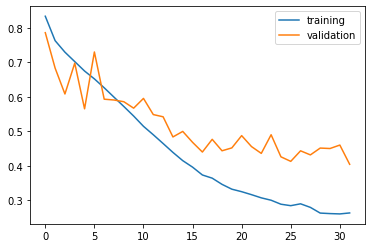

In [43]:
%matplotlib inline

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

name = "model1_epoch32_1"
plt.savefig('../result/loss/' + name + '.png', dpi=200)

plt.show()

# Evaluation

## evaluation tools

In [56]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png', dpi=200)
    return ax

In [21]:
def predict_on_df(model, df):
    dg = DataGenerator(df, batch_size=32, shuffle=False)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['equation', 'pred_label', 'source', 'pred_index', 'label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [22]:
predictions = predict_on_df(model, val_df)


Confusion matrix, without normalization
[[44341  4509  1577]
 [ 1366  5536   311]
 [  260   169   212]]


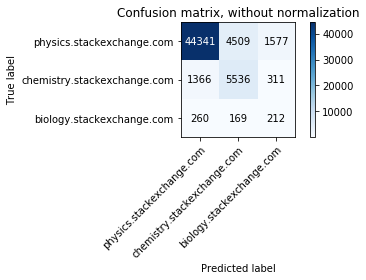

In [57]:
name = "model1_epoch32_1"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.87931069 0.08941638 0.03127293]
 [0.18938029 0.76750312 0.0431166 ]
 [0.40561622 0.26365055 0.33073323]]


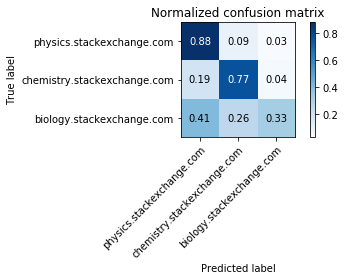

In [58]:
name = "model1_epoch32_2"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [30]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.8189523220062256, 0.18104767799377441, 3.1142073364520684e-09]],
 'pred_index': 0,
 'label': 'physics.stackexchange.com'}

In [59]:
display_top_losses(predictions, 20)

,equation,pred_label,source,pred_index,label,pred_conf
1189809,\ce{C_\alpha},biology.stackexchange.com,chemistry.stackexchange.com,2,1,0.999996
1244828,S_{\text{target}}=2^{(1-0.5\log C)}.,biology.stackexchange.com,chemistry.stackexchange.com,2,1,0.999994
575749,5 \hspace{.5mm} \theta/11,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999971
648462,\ce{^0_{-1}\beta},chemistry.stackexchange.com,physics.stackexchange.com,1,0,0.999963
1345831,\ce{^12C},chemistry.stackexchange.com,biology.stackexchange.com,1,2,0.999958
1144132,"\alpha \in ( 0.1, 1, 3, 10, 100 )",biology.stackexchange.com,physics.stackexchange.com,2,0,0.999940
1345832,\ce{^13C},chemistry.stackexchange.com,biology.stackexchange.com,1,2,0.999938
339689,m_c ≈ 1.5,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999921
1338914,\ce {K+_{out}}=5 \text{mmoll}^{-1},chemistry.stackexchange.com,biology.stackexchange.com,1,2,0.999902
133007,\text{(homogenous and isotropic)} \iff \nabla_...,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999892
